In [14]:
from osgeo import gdal, osr
import os
import numpy as np
import logging
from dateutil.relativedelta import relativedelta
from datetime import datetime
import netCDF4 as nc4
import h5py as h5py 
import requests
#from IPython.core.debugger import set_trace
import gpm2local

In [15]:
def get_boundingbox_country(country, output_as='boundingbox'):
    """
    get the bounding box of a country in EPSG4326 given a country name
    
    Parameters
    ----------
    country : str
        name of the country in english and lowercase
    output_as : 'str
        chose from 'boundingbox' or 'center'. 
         - 'boundingbox' for [latmin/ymin, latmax/ymax, 
                              lonmin/xmin, lonmax/xmax]
         - 'center' for [latcenter, loncenter]
    
    Returns
    -------
    output : list
        list with coordinates as str
    """
    url = '{0}{1}{2}'.format('http://nominatim.openstreetmap.org/search?country=',
                             country,
                             '&format=json&polygon=0')
    response = requests.get(url).json()[0]
    # set_trace()
    if output_as == 'boundingbox':
        lst = response[output_as]
        output = [float(i) for i in lst]
    if output_as == 'center':
        lst = [response.get(key) for key in ['lat','lon']]
        output = [float(i) for i in lst]
    try:
        return output
    except:
        return response

In [17]:
# country = 'nl'
# datetime_of_interest = datetime(2017,11,1,12)
# period = 2

# # get extent from country    
# extent = hdf2nc.get_boundingbox_country(country)

# # list ftp of last two months
# df = gpm2hdf.list_ftp(date=datetime_of_interest)

# # get selection that fits the period
# T0 = df.iloc[df.index.get_loc(gpm2hdf.get_utc(datetime_of_interest), method='nearest')]
# sel_gpm_files = df.loc[T0.name - relativedelta(hours=period):T0.name]

# # fetch gpm-files
# outfiles = gpm2hdf.fetch_GPM_IMERG(sel_gpm_files, outdir = outdir)

# # init netcdf by using first hdf-file
# hdf_file = os.path.join(outdir,sel_gpm_files.iloc[0]['name'])
# array, x, y, nan_value = hdf2nc.hdf2tif(hdf_file, extent)

In [18]:
datetime_of_interest

datetime.datetime(2017, 11, 1, 12, 0)

In [19]:
# def window_from_extent(xmin, xmax, ymin, ymax, aff):
#     col_start, row_start = ~aff * (xmin, ymax)
#     col_stop, row_stop = ~aff * (xmax, ymin)
#     return ((int(row_start), int(row_stop)), (int(col_start), int(col_stop)))

In [20]:
def coord(file):
    """
    function to get coordinates of gdal array computed from GeoTransform
    """
    padfTransform = file.GetGeoTransform()
    indices = np.indices(file.ReadAsArray().shape)
    xp = padfTransform[0] + indices[1]*padfTransform[1] + indices[1]*padfTransform[2]   
    yp = padfTransform[3] + indices[0]*padfTransform[4] + indices[0]*padfTransform[5]  
    return xp,yp

In [21]:
def create_tif(destName, array, fill_value, rows, cols, top_left_x, top_left_y, x_step=0.1, y_step=0.1, rotation=0):
    """
    function to create tif file
    """
    
    # Create output tiff file.
    # driver.Create() parameters are: output path, number of columns, number of rows,
    # number of bands, data type
    driver = gdal.GetDriverByName("GTiff")
    out_tif = driver.Create(destName, cols, rows, 1, gdal.GDT_Float32)

    # Create Spatial Reference object and set GeoTIFF projection.
    # This information may be found in either the data documentation or the netCDF file.
    prj = osr.SpatialReference()
    prj.ImportFromEPSG(4326) # WGS84
    out_tif.SetProjection(prj.ExportToWkt())

    # Set GeoTransformation.
    # This information may be found in either the data documentation, the netCDF file, or
    # can be derived. For example, if you know the longitude range and number of columns
    # you can calculate the x step as float(lon_range)/float(num_cols).
    geotrans = [top_left_x,x_step,rotation,top_left_y,rotation,-y_step]
    out_tif.SetGeoTransform(geotrans)

    # Finally we can write the array to the raster band.
    out_band = out_tif.GetRasterBand(1)    
    out_band.SetNoDataValue(fill_value)
    out_band.WriteArray(array)

    # Clear the memory and close the output file.
    out_tif.FlushCache()
    out_tif = None

In [22]:
def hdf2tif(hdf_file, extent):
    """
    function to convert hdf file to tif using an given extent
    
    Parameter
    ---------
    hdf_file : str
        path to hdf file
    extent : list
        bounding box of extent to clip from hdf_file 
        list is [ymin, ymax, xmin, xmax] (coords in epsg4326)
        
    Returns
    -------
    array : np.array
        array containing the values of clipped extent
    x : np.array
        longitude coordinates of array
    y : np.array
        latitude coordinates of array
    nan_value : float
        fill value of array
    """
    dataset = h5py.File(hdf_file, 'r')

    # # get metadata
    # for attr_name in dataset['Grid/precipitationCal'].attrs:
    #     print('attr_name : {0}\nattr_value: {1}\n'.format(
    #         attr_name,
    #         dataset['Grid/precipitationCal'].attrs[attr_name]))

    fill_value = dataset['Grid/precipitationCal'].attrs['_FillValue'].astype(float)

    # get data
    precip = dataset['Grid/precipitationCal'][:]
    precip = np.transpose(precip) 

    # get lon/lat array
    lats = dataset['Grid/lat'][:]
    lons = dataset['Grid/lon'][:]

    # get array dimensions
    rows, cols = (len(lats), len(lons))

    # get top-left coordinate + stepsize
    top_left_x = lons.min()
    top_left_y = lats.max()
    x_step = 0.1
    y_step = 0.1
    rotation = 0

    # write to tif
    destName = r'D:\My Projects\gpm2thredds\trunk\test\tmp.tif'
    create_tif(destName, precip, fill_value, rows, cols, top_left_x, top_left_y, x_step, y_step)

#     # prepare for gdalwrap
#     xmin = extent[2]
#     xmax = extent[3]
#     ymin = extent[0]
#     ymax = extent[1]

#     srcDS = destName
#     desDS = r'D:\My Projects\gpm2thredds\trunk\test//clipped_data.tif'
#     warp_options = gdal.WarpOptions(outputBounds=(xmin, ymin, xmax, ymax))
#     res = gdal.Warp(desDS, srcDS, options=warp_options)

    # open cipped array and check extent
    ds = gdal.Open(destName, gdal.GA_ReadOnly) # A GeoTiff file
    x,y = coord(ds)
    band = ds.GetRasterBand(1)
    nan_value = band.GetNoDataValue()
    array = band.ReadAsArray()
    print('x: {0}\ny: {1}'.format(x[0][np.r_[0, -1]],y[:,0][np.r_[0, -1]]))
    ds = None
    return array, x, y, nan_value

In [23]:
def init_netcdf(x, y, nan_value, desNC = r'D:\My Projects\gpm2thredds\trunk\test//hours_two.nc'):
    """
    function to initate a netcdf file given the longitude, latitude and nan_value
    
    Parameters
    ----------
    x : numpy.array
        1 dimensional array providing the values on longitude axis (from left to right)
    y : numpy.array
        1 dimensional array providing the values on latiude axis (from top to bottom)
    nan_value : float
        value that is used as fill value for the precipitation variable
    desNC : str
        destination netcdf file, path to write
    
    Returns
    -------
    f : nc4.Dataset
        netcdf4 parent dataset
    nc_prc : nc4.Variable
        netcdf4 child variable, in this case the precipitation variable
    nc_time : nc4.Variable
        netcdf4 child variable, in this case the time variable
    """
    
    
    f = nc4.Dataset(desNC,'w', format='NETCDF4') #'w' stands for write

    # create group
    precipgrp = f.createGroup('3IMERG')    
    
    # create dimensions
    precipgrp.createDimension('lon', len(x[0]))
    precipgrp.createDimension('lat', len(y[:,0]))
    precipgrp.createDimension('time', None)    
    
    # create variables
    nc_lon = precipgrp.createVariable('Longitude', 'f4', 'lon')
    nc_lat = precipgrp.createVariable('Latitude', 'f4', 'lat')  
    nc_prc = precipgrp.createVariable('Precipitation', 'f4', ('time', 'lon', 'lat'), fill_value=nan_value)
    nc_time = precipgrp.createVariable('Time', 'i4', 'time')    
    
    # fill variables
    nc_lon[:] = x[0]
    nc_lat[:] = y[:,0]

    # add global attributes
    f.description = "NETCDF File containing GPM 3IMERG data"    

    # add local attributes to variable instances
    nc_lon.units = 'degrees_east'
    nc_lon.axis = 'X'
    
    nc_lat.units = 'degrees_north'
    nc_lat.axis = 'Y'
    
    nc_prc.units = 'millimeter hour-1'
    nc_prc.long_name = 'precipitation in millimeter per hour'
    
    nc_time.units = 'seconds since 1970-01-01 00:00:00 UTC'
    nc_time.long_name = 'time in seconds since epoch'
    nc_time.standard_name = 'time'
    nc_time.axis = 'T'      

    return f, nc_prc, nc_time    

In [24]:
"""
test the fetch_gpm function to get all images from last two hours available
"""
period = [2,8,12,48] # hours
outdir = r'D:\My Projects\gpm2thredds\trunk\test\test_fetch_gpm'
#outdir = os.path.join(os.path.dirname(__file__), 'test_fetch_gpm')
outfiles = []
datetime_of_interest = datetime.now()

# list ftp
df = gpm2local.list_ftp(date=datetime_of_interest)
T0 = df.iloc[df.index.get_loc(gpm2local.get_utc(datetime_of_interest),method='nearest')]
logging.info('from : {0}'.format(T0.name - relativedelta(hours=period[0])))
logging.info('to   : {0}'.format(T0.name))
sel_gpm_files = df.loc[T0.name - relativedelta(hours=period[0]):T0.name]

# fetch gpm-files
outfiles = gpm2local.fetch_GPM_IMERG(sel_gpm_files, outdir = outdir)

In [25]:
sel_gpm_files.name#.strftime('%Y%m')

date_start
2018-01-11 06:30:00+00:00    3B-HHR-E.MS.MRG.3IMERG.20180111-S063000-E06595...
2018-01-11 07:00:00+00:00    3B-HHR-E.MS.MRG.3IMERG.20180111-S070000-E07295...
2018-01-11 07:30:00+00:00    3B-HHR-E.MS.MRG.3IMERG.20180111-S073000-E07595...
2018-01-11 08:00:00+00:00    3B-HHR-E.MS.MRG.3IMERG.20180111-S080000-E08295...
2018-01-11 08:30:00+00:00    3B-HHR-E.MS.MRG.3IMERG.20180111-S083000-E08595...
Name: name, dtype: object

In [26]:
# get extent from country
extent = get_boundingbox_country(country='nl')
print('x-min_max {2} {3}\ny-min_max {0} {1}'.format(
    extent[0], extent[1], extent[2], extent[3]))

x-min_max -70.2695876 7.2274985
y-min_max 11.777 53.7253321


In [27]:
outfiles

['D:\\My Projects\\gpm2thredds\\trunk\\test\\test_fetch_gpm\\3B-HHR-E.MS.MRG.3IMERG.20180111-S063000-E065959.0390.V05B.RT-H5',
 'D:\\My Projects\\gpm2thredds\\trunk\\test\\test_fetch_gpm\\3B-HHR-E.MS.MRG.3IMERG.20180111-S070000-E072959.0420.V05B.RT-H5',
 'D:\\My Projects\\gpm2thredds\\trunk\\test\\test_fetch_gpm\\3B-HHR-E.MS.MRG.3IMERG.20180111-S073000-E075959.0450.V05B.RT-H5',
 'D:\\My Projects\\gpm2thredds\\trunk\\test\\test_fetch_gpm\\3B-HHR-E.MS.MRG.3IMERG.20180111-S080000-E082959.0480.V05B.RT-H5',
 'D:\\My Projects\\gpm2thredds\\trunk\\test\\test_fetch_gpm\\3B-HHR-E.MS.MRG.3IMERG.20180111-S083000-E085959.0510.V05B.RT-H5']

In [28]:
#path_in = r'D:\My Projects\gpm2thredds\trunk\test\test_fetch_gpm'

hdf_file = os.path.join(outdir,sel_gpm_files.iloc[0]['name'])
array, x, y, nan_value = hdf2tif(hdf_file, extent)
f, nc_prc, nc_time = init_netcdf(x, y, nan_value)

x: [-179.94999695  179.95000305]
y: [ 89.94999695 -89.95000305]


In [41]:
array_ma = np.ma.masked_where(array == nan_value, array)
array_ma = np.ma.masked_where(array_ma == 0, array_ma)

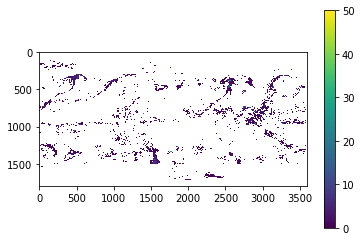

In [42]:
from matplotlib import pyplot as plt
%matplotlib inline
im = plt.imshow(array_ma, vmin=0)
plt.colorbar(im)

In [47]:
array_ma.sum()
f.close()

In [48]:
for idx, gpm_file in sel_gpm_files.iterrows():
    print(idx)
    print(gpm_file['name'])
    
    hdf_file = os.path.join(outdir,gpm_file['name'])
    array, x, y, nan_value = hdf2tif(hdf_file, extent)
    #f, nc_prc, nc_time = init_netcdf(x, y, nan_value)

    array_ma = np.ma.masked_where(array == nan_value, array)
    array_ma = np.ma.masked_where(array_ma == 0, array_ma)    
    
    cum_precip = array_ma.sum()
    
    print(cum_precip)
    print('\n')

2018-01-11 06:30:00+00:00
3B-HHR-E.MS.MRG.3IMERG.20180111-S063000-E065959.0390.V05B.RT-H5
x: [-179.94999695  179.95000305]
y: [ 89.94999695 -89.95000305]
596233.0


2018-01-11 07:00:00+00:00
3B-HHR-E.MS.MRG.3IMERG.20180111-S070000-E072959.0420.V05B.RT-H5
x: [-179.94999695  179.95000305]
y: [ 89.94999695 -89.95000305]
600981.0


2018-01-11 07:30:00+00:00
3B-HHR-E.MS.MRG.3IMERG.20180111-S073000-E075959.0450.V05B.RT-H5
x: [-179.94999695  179.95000305]
y: [ 89.94999695 -89.95000305]
593929.0


2018-01-11 08:00:00+00:00
3B-HHR-E.MS.MRG.3IMERG.20180111-S080000-E082959.0480.V05B.RT-H5
x: [-179.94999695  179.95000305]
y: [ 89.94999695 -89.95000305]
598034.0


2018-01-11 08:30:00+00:00
3B-HHR-E.MS.MRG.3IMERG.20180111-S083000-E085959.0510.V05B.RT-H5
x: [-179.94999695  179.95000305]
y: [ 89.94999695 -89.95000305]
583464.0




In [ ]:
S_E = sel_gpm_files.index[np.r_[0, -1]]
S = S_E[0].strftime('S%Y%m%d-%H%M.%p')
E = S_E[1].strftime('E%Y%m%d-%H%M.%p')

In [ ]:
idx = 0
for i, row in sel_gpm_files.iterrows(): 
    #print(idx)
    # get start timestamp
    tstamp = sel_gpm_files.iloc[idx].name
    # get name hdf file
    hdf_file = os.path.join(outdir,sel_gpm_files.iloc[idx]['name'])
    # get subset array
    array, x, y, nan_value = hdf2tif(hdf_file, extent)
    # set array in netcdf
    nc_prc[idx,:,:] = np.flipud(array.T)  
    # set timestamp in netcdf (in seconds since epoch)
    nc_time[idx] = tstamp.timestamp()
    idx += 1
f.history = "Created " + datetime.now().strftime("%d/%m/%Y | %H:%M %p")
f.close()